In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['font.family']= 'open sans'

from scipy import stats
from mpmath import hyp3f2, beta
from statsmodels.stats.diagnostic import normal_ad


from rdn.defaults import pardict_from_result
from rdn.fitting.pipeline import *
from rdn.fitting.models import LocalGaussModelTilde, MultiInterface
from rdn.fitting.losses import *

from rdn.stochastic.experiments import linear_experiment


Import the fitting result

In [4]:
model = LocalGaussModelTilde()
multi_interface = MultiInterface(model)
loss_fn = NLLAdast()
n_starts = 1200

nsss = [1,3,5,7]


## Optimization ####
problem = setup_multi_pypesto_problem(
    nsss,
    multi_interface,
    loss_fn,
    plot_data=False
)

result = optimize_multi_problem(
    nsss,
    multi_interface,
    loss_fn,
    problem,
    n_starts,
    mode='multi_fitting',
    force_optimization=False,
)

ress_a = result.optimize_result[0:437]

par_names = problem.x_names
best_res = result.optimize_result.x[0]

# Take the optimized basal k and n distributions (log 10)
best_log10_kb = np.array([kb for kb, parname in zip(best_res, par_names) if '_Kb' in parname])
best_log10_nb = np.array([nb for nb, parname in zip(best_res, par_names) if '_Nbo' in parname])

# Transform into normal log
best_log_kb = best_log10_kb * np.log(10)
best_log_nb = best_log10_nb * np.log(10)

# Add omega and dendritic length
best_log_kb += np.log(5000*1000)
best_log_nb += np.log(5000)

/home/janko/code/pyPESTO/pypesto/store/read_from_hdf5.py:124: UserWarning: You are loading a problem. This problem is not to be used without a separately created objective.
  warnings.warn(


Result already present, using old one with same parameters


Import the model_p_dict dictionary

In [5]:
model_p_dict = pardict_from_result(
    'output/multi_fitting/Multi_LocalGaussModelTilde/'
    'NLLAdast/1_3_5_7_Spine_data_fides_1200.hdf5',
    Chi=1, dendrite_length=1000, N_mean=5000, run_index=0
)


Basal K distribution:
- Sample size: 59
- Mean: 4017.7537474693586 +- 2746.5237188826472
- Anderson test on log: AndersonResult(statistic=np.float64(0.36243150482356157), critical_values=array([0.543, 0.619, 0.742, 0.866, 1.03 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(8.106764691950193), scale=np.float64(0.6245301761906116))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Basal N distribution:
- Sample size: 58
- Mean: 8070.943955026876 +- 5225.598876296613
- Anderson test on log: AndersonResult(statistic=np.float64(0.5003716373876728), critical_values=array([0.543, 0.618, 0.741, 0.865, 1.029]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(8.820978310112448), scale=np.float64(0.5968557991311232))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Correlation matrix between log K_b and log

Import and prepare the helm data

In [6]:
helm_df = pd.read_csv('data/validation_data/helm_data/lognom_proteins.csv')

df_camkii = helm_df[helm_df['protein']=='CaMKII']
df_can = helm_df[helm_df['protein']=='Calcineurin']


Import the goda sizes

In [7]:
goda_base_sizes = np.load('data/validation_data/goda_data/log_base_sizes.npy')

In [8]:
def pham_gia_ratio_cdf(a1, a2, b1, b2, z):

    Y = []
    
    for x in z:
    
        if x<0: raise ValueError('The beta ratio distribution is defined only for postive values')

        if x<=1:
            Y.append(float(
                beta(a1+a2, b2) * x**a1 / 
                (beta(a1,b1) * beta(a2,b2) * a1) *
                hyp3f2(a1, a1+a2, 1-b1, a1+1, a1+a2+b2, x)
            ))

        else:
            Y.append(float(
                1 - 
                beta(a1+a2, b1) /
                (beta(a1,b1) * beta(a2,b2) * a2 * x**a2)
                * hyp3f2(a2, a1+a2, 1-b2, a2+1, a1+a2+b1, 1/x)
            ))

    return np.array(Y)

In [9]:
def lognorm_plot(ax, data, n_bins=9, **kwargs):

    _, p = normal_ad(data)
    print(len(data))
    
    _, bins, _ = ax.hist(data, bins=n_bins, density=True,
        color=kwargs.get('color'), alpha=kwargs.get('alpha'),
    )

    if p >= 0.05:

        res = stats.norm.fit(data)
        
        if kwargs.get('x_lim') is None: x_lim = (bins[[0,-1]]-bins.mean())*1.5 +bins.mean()
        else: x_lim = kwargs.get('x_lim')

        X = np.linspace(x_lim[0], x_lim[1],100)
        fitline = ax.plot(X, stats.norm.pdf(X, *res), color=kwargs.get('linecolor'), linewidth=3)

    ax.set_xticks(bins[[0,-1]], (f'{bins[0]:.1f}',f'{bins[-1]:.1f}'))
    ax.set_yticks([])
    
    for k, v in ax.spines.items(): 
        if k != 'bottom': v.set_visible(False)

    # External formatting
    ax.set_xlim(x_lim)
    ax.set_xlabel(kwargs.get('xlabel'), labelpad=0, fontsize=12)
    ax.set_ylabel(kwargs.get('ylabel'), labelpad=0, fontsize=12)

    if p >= 0.05: return p, fitline
    else: return None, None
    

def correlation_plot(ax, X, Y, **kwargs):
    s,i,r,p,e = stats.linregress(X,Y)

    ax.scatter(X,Y, 
        color=kwargs.get('color'), 
        alpha=kwargs.get('alpha'),
        linewidths=0,
        s=22,
    )

    if p < 0.05:
        XX = np.linspace(X.min(), X.max(), 2)
        line = ax.plot(
            XX, i + s*XX, 
            color=kwargs.get('linecolor'),
            linestyle=(0,(5,3)),
            linewidth=2,
        )
        # print(p)

    for s in ax.spines.values():
        s.set_visible(True)

    ax.set_xlabel(kwargs.get('xlabel'), labelpad=0, fontsize=12)
    ax.set_ylabel(kwargs.get('ylabel'), labelpad=0, fontsize=12)

    if p < 0.05: return r, line
    else: return None, None



def plot_kn_joint(ax, best_log_k, best_log_n, model_p_dict, seed=2025):
    
    np.random.seed(seed)
    sample_log_k, sample_log_n = np.random.multivariate_normal(
        model_p_dict['mu_log_K_N'],
        model_p_dict['cov_log_K_N'],
        size=3000,
    ).T

    sample_k, sample_n = np.exp(sample_log_k), np.exp(sample_log_n)

    best_k, best_n = np.exp(best_log_k), np.exp(best_log_n)
    # best_k, best_n = best_log_k, best_log_n

    K = np.linspace(0, best_k.max()*1.1, 100)
    N = np.linspace(0, best_n.max()*1.1, 100)

    KK, NN = np.meshgrid(K, N)

    kernel = stats.gaussian_kde([sample_n, sample_k])
    density = kernel([NN.flatten(), KK.flatten()]).reshape(NN.shape)

    ctr = ax.contourf(N, K, density.T, cmap='Blues', levels=50, alpha=1, antialiased=True)
    ax.scatter(best_n, best_k, marker='x', c='navy', s=20, linewidths=.3, label='parameter\nestimates')

    ax.legend(fontsize=9, markerscale=2)

    ax.ticklabel_format(axis='both', scilimits=(0,1))
    ax.set_xlabel(r'$N_b^{(i)}$', labelpad=0, fontsize=12)
    ax.set_ylabel(r'$K_b^{(i)}$', labelpad=0, fontsize=12)
    
    clb = plt.colorbar(ctr, pad=.17, shrink=.6, ticks=[0, 2.5e-8, 5e-8])
    clb.set_label('probability\ndensity', labelpad=-50, fontsize=10)




In [10]:
c_k = 'forestgreen'
c_n = 'mediumvioletred'
c_n = 'darkorchid'
c_p = 'tab:blue'

110
133
59
58
1000
1105
1000


Text(0.5, 1.15, 'Quantile-Quantile plot')

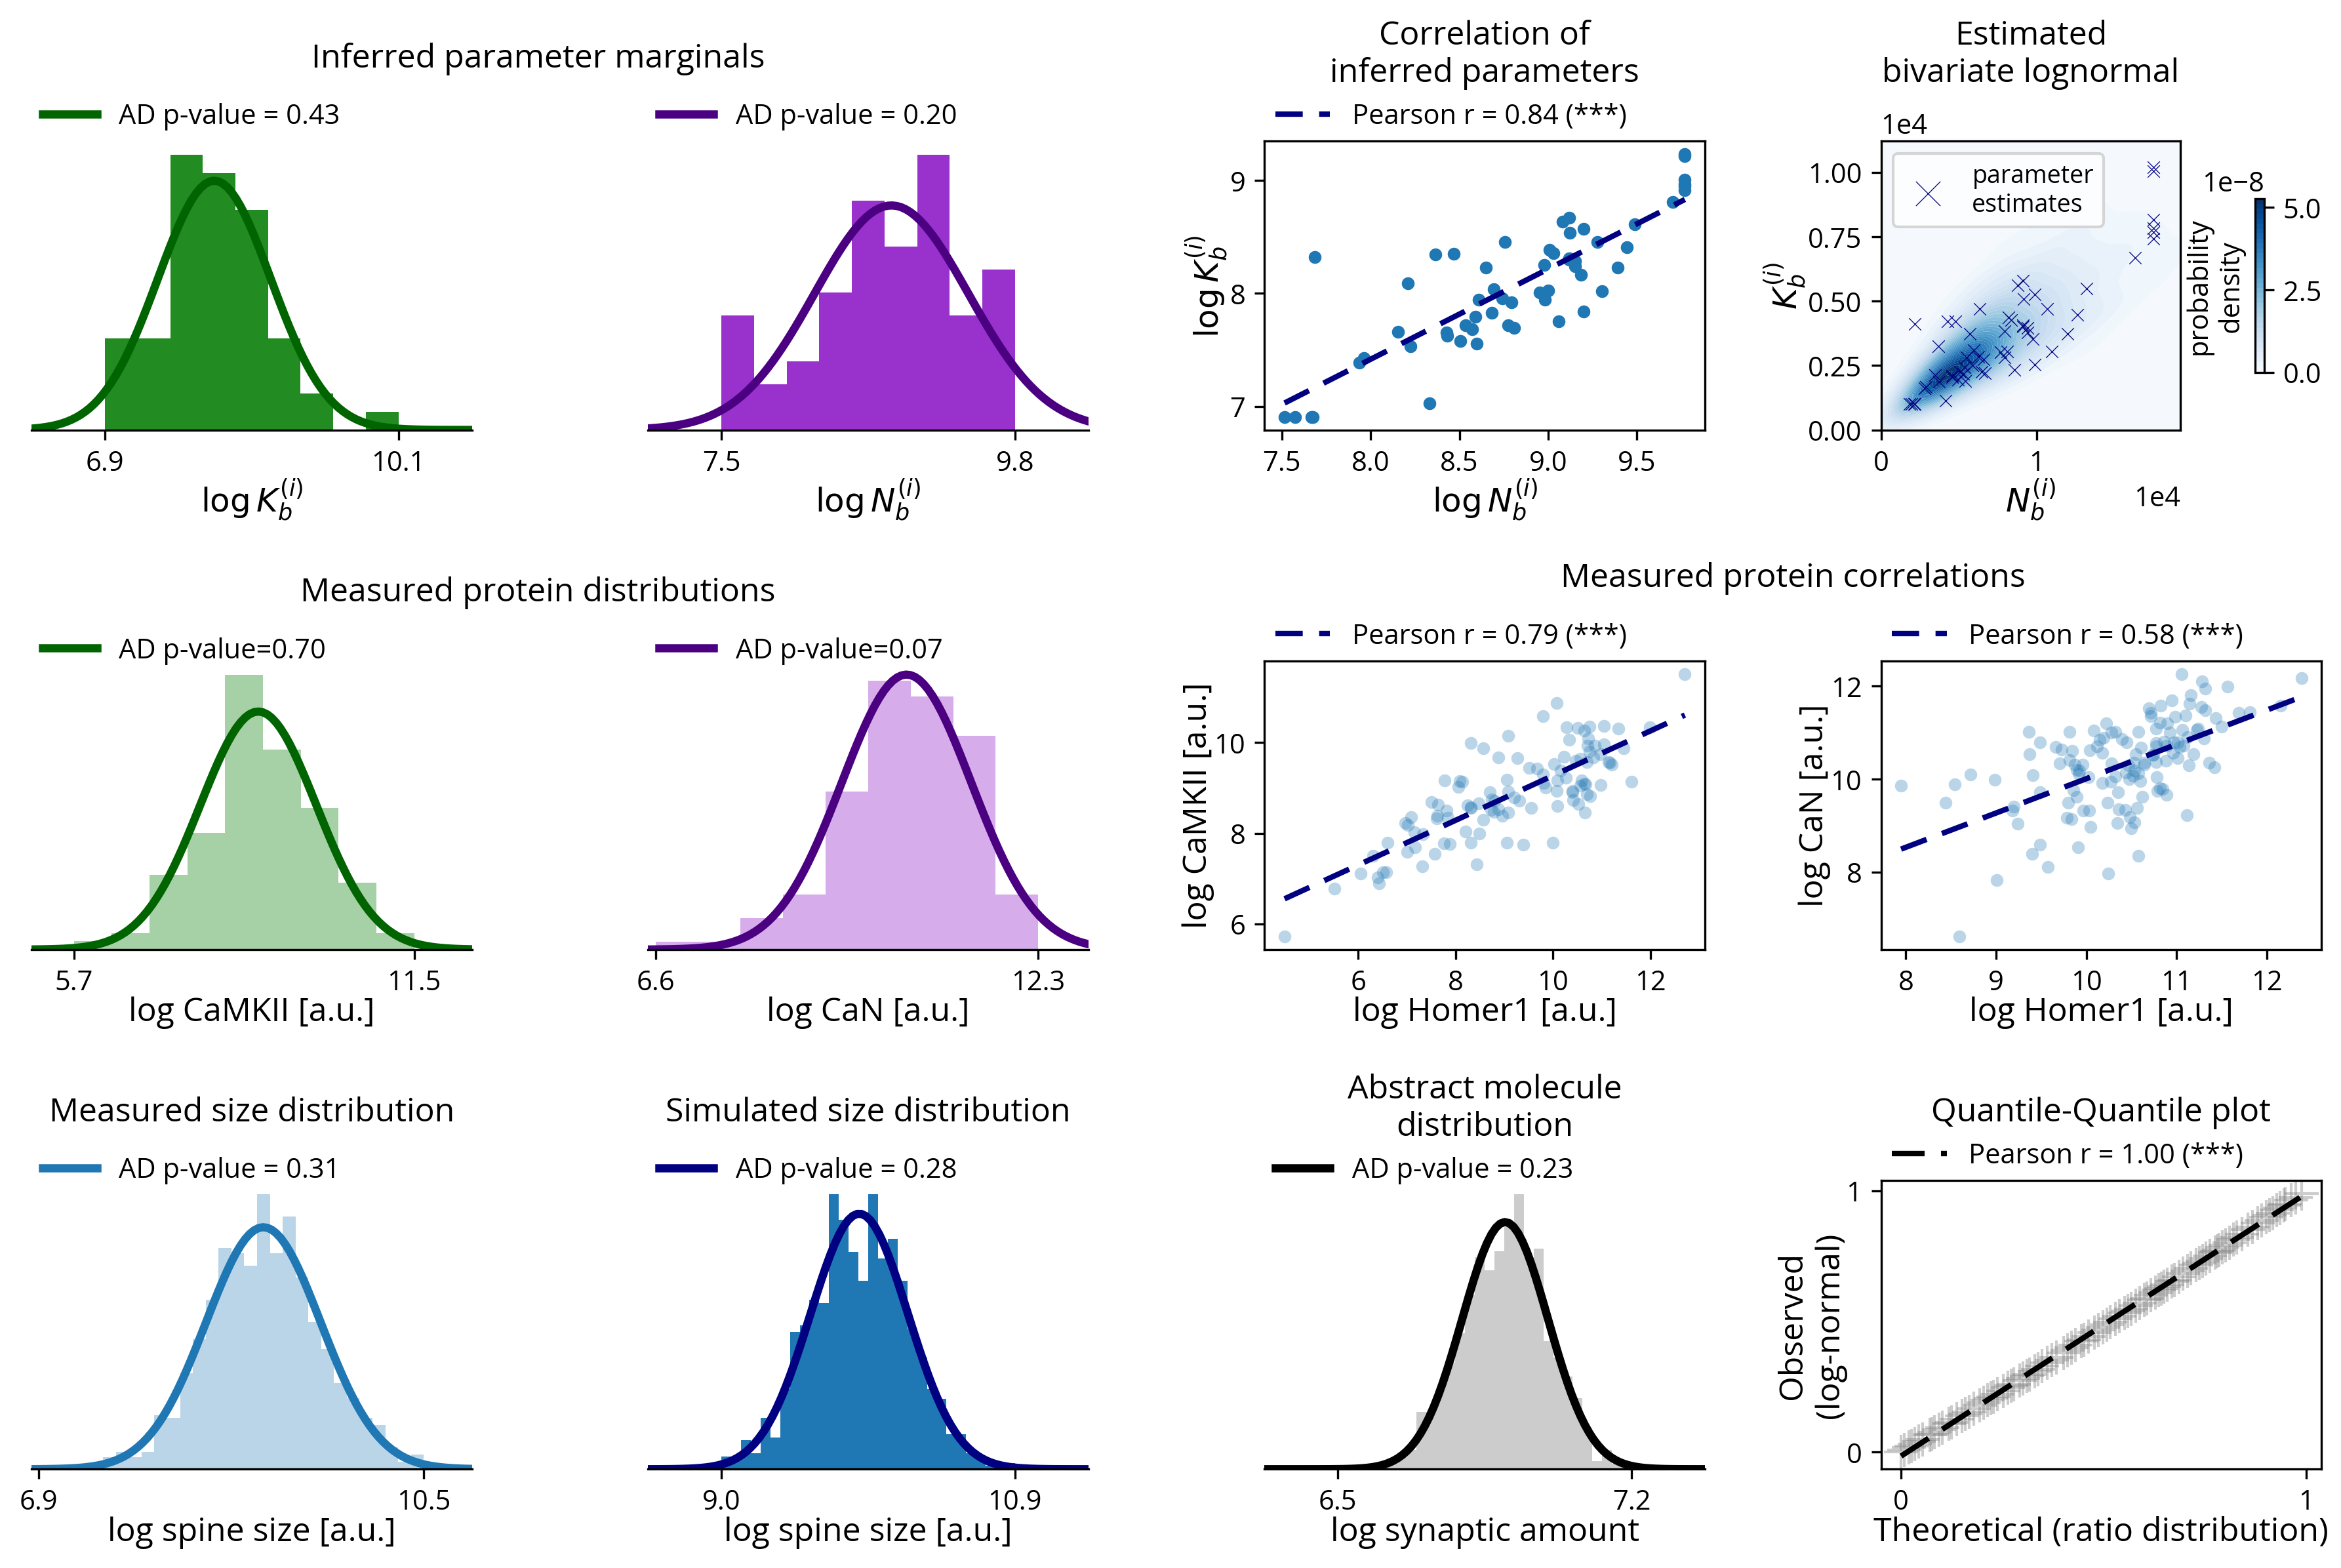

In [11]:
fig, axs = plt.subplots(3,4, figsize=(12,9), dpi=300)
fig.subplots_adjust(left=0.02, bottom=0.1, right=0.99, top=0.85, wspace=0.4, hspace=0.8)


def upper_section(axs):
    # Upper section
    pk, line_k = lognorm_plot(axs[0], best_log_kb, color=c_k, linecolor='darkgreen', xlabel=r'$\log K^{(i)}_b$')

    pn, line_n = lognorm_plot(axs[1], best_log_nb, color=c_n, linecolor='indigo', xlabel=r'$\log N^{(i)}_b$')

    rkn, line_kn = correlation_plot(axs[2], best_log_nb, best_log_kb[:-1],
                                    color=c_p,
                                    linecolor='navy',
                                    xlabel=r'$\log N^{(i)}_b$',
                                    ylabel=r'$\log K^{(i)}_b$')

    plot_kn_joint(axs[3], best_log_kb[:-1], best_log_nb, model_p_dict)

    axs[0].legend(line_k, [f'AD p-value = {pk:.2f}'], frameon=False, loc=[0.,1])
    axs[1].legend(line_n, [f'AD p-value = {pn:.2f}'], frameon=False, loc=[0.,1])
    axs[2].legend(line_kn, [f'Pearson r = {rkn:.2f} (***)'], frameon=False, loc=[0.,1])


# Middle section
pcam, line_cam = lognorm_plot(
    axs[1,0], df_camkii['poi'],
    color=c_k, linecolor='darkgreen', alpha=0.4,
    xlabel='log CaMKII [a.u.]', x_lim=[5,12.5])

pcan, line_can = lognorm_plot(
    axs[1,1], df_can['poi'],
    color=c_n, linecolor='indigo', alpha=0.4, 
    xlabel='log CaN [a.u.]', x_lim=[6.5, 13])

rhc, line_hc = correlation_plot(
    axs[1,2], df_camkii['Homer'], df_camkii['poi'],
    color=c_p,
    alpha=0.3,
    linecolor='navy',
    xlabel='log Homer1 [a.u.]',
    ylabel='log CaMKII [a.u.]'
)

rhn, line_hn = correlation_plot(
    axs[1,3], df_can['Homer'], df_can['poi'],
    color=c_p,
    alpha=0.3,
    linecolor='navy',
    xlabel='log Homer1 [a.u.]',
    ylabel='log CaN [a.u.]'
)

axs[1,0].legend(line_cam, [f'AD p-value={pcam:.2f}'], frameon=False, loc=[0.,.95])
axs[1,1].legend(line_can, [f'AD p-value={pcan:.2f}'], frameon=False, loc=[0.,.95])
axs[1,2].legend(line_hc, [f'Pearson r = {rhc:.2f} (***)'], frameon=False, loc=[-0.0,1])
axs[1,3].legend(line_hn, [f'Pearson r = {rhn:.2f} (***)'], frameon=False, loc=[-0.0,1])

# Annotations: titles

a_beta_in = 70
b_beta_in = 70
a_beta_out = 100
b_beta_out = 100

def lower_section(axs, model_p_dict, Omega, spine_number, seed=2023):

    # Generate the concentrations deriving from random diffusion
    def plot_diffusion_simulation(axs):

        # Stimulate and get synaptic distributions
        p_out_t, p_in_t = linear_experiment(
            a_beta_in = a_beta_in,
            b_beta_in = b_beta_in,
            a_beta_out = a_beta_out,
            b_beta_out = b_beta_out,
        )
        p = p_in_t[-1].astype(float)
        logp = np.log(p_in_t[-1])


        ax = axs[0]
        plogp, line_logp = lognorm_plot(
            ax, logp,
            n_bins=30,
            color='gray',
            linecolor='black',
            xlabel='log synaptic amount',
            alpha=0.4,
            # x_lim=[6.8,11]
        )
        
        ax.legend(line_logp, [f'AD p-value = {plogp:.2f}'], frameon=False, loc=[0.,0.95])


        res = stats.lognorm.fit(p,floc=0)

        q = np.array([
            np.quantile(p, i/100) for i in range(100)    
        ])

        X = stats.lognorm.cdf(q, *res)
        Y = pham_gia_ratio_cdf(a_beta_in,a_beta_out,b_beta_in,b_beta_out,q/1000)

        s,i,r,p,e = stats.linregress(X,Y)

        ax = axs[1]
        ax.scatter(X,Y,
            alpha=0.4,
            s=150,
            c='gray',
            marker='+',
            linewidths=1,
            # edgecolors='white',
        )

        ax.plot(
            X, i + s*X,
            c='black',
            linewidth=2,
            linestyle=(0,(6,3)),
            label=f'Pearson r = {r:.2f} (***)'
        )

        ax.legend(frameon=False, loc=(0,1))
        ax.set_xticks([0,1])
        ax.set_yticks([0,1])
        ax.set_xlabel(r'Theoretical (ratio distribution)', labelpad=0, fontsize=12)
        ax.set_ylabel('Observed\n(log-normal)', labelpad=0, fontsize=12)
    

    # Plotting
    plot_diffusion_simulation(axs[2:])
    
    psize, line_size = lognorm_plot(
        axs[0], goda_base_sizes,
        n_bins=30,
        color=c_p,
        linecolor=c_p,
        alpha=0.3,
        xlabel='log spine size [a.u.]',
        x_lim=[6.8,11]
    )

    # Generate the simulated spine sizes
    np.random.seed(seed)
    log_Kbs, log_Nbs = np.random.multivariate_normal(
        model_p_dict['mu_log_K_N'],
        model_p_dict['cov_log_K_N'],
        spine_number
    ).T

    Kbs = np.exp(log_Kbs)
    Nbs = np.exp(log_Nbs)

    alphas = Kbs/Nbs
    sim_sizes = (
        model_p_dict['Pi'] * alphas / (Omega + alphas.sum())
    )

    log_simsizes = np.log(sim_sizes)
    psimsize, line_simsize = lognorm_plot(
        axs[1], log_simsizes,
        n_bins=30,
        linecolor='navy',
        xlabel='log spine size [a.u.]',
        # x_lim=[6.8,11]
    )

    axs[0].legend(line_size, [f'AD p-value = {psize:.2f}'], frameon=False, loc=[0.,0.95])
    axs[1].legend(line_simsize, [f'AD p-value = {psimsize:.2f}'], frameon=False, loc=[0.,0.95])

upper_section(axs[0])
lower_section(axs[2], model_p_dict, 1000, 1000)


weight = 'regular'
axs[0,0].set_title('Inferred parameter marginals', weight=weight, x=1.15, y=1.2)
axs[0,2].set_title('Correlation of\ninferred parameters', weight=weight, y=1.15)
axs[0,3].set_title('Estimated\nbivariate lognormal', weight=weight, y=1.15)
axs[1,0].set_title('Measured protein distributions', weight=weight, x=1.15, y=1.15)
axs[1,2].set_title('Measured protein correlations', weight=weight, x=1.2, y=1.2)
axs[2,0].set_title('Measured size distribution', weight=weight, y=1.15)
axs[2,1].set_title('Simulated size distribution', weight=weight, y=1.15)
axs[2,2].set_title('Abstract molecule\ndistribution', weight=weight, y=1.1)
axs[2,3].set_title('Quantile-Quantile plot', weight=weight, y=1.15)

# plt.savefig('figures/results/figure_lognormal.png', dpi=300)
# plt.savefig('docs/figures-paper/figure-2-lognormal.png', dpi=300)
# plt.savefig('docs/figures-paper/svgs/figure-2-lognormal.svg', dpi=300)
